In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('fivethirtyeight')
from textblob import TextBlob
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

import warnings
warnings.filterwarnings('ignore')

In [9]:

#Reading from Drive
from google.colab import drive
drive.mount('/content/gdrive')
#df=pd.read_csv('gdrive/My Drive/data.csv')
df = pd.read_csv('gdrive/My Drive/Research/form/large_files/sen/train.csv')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df.head()

,date,tweet,hashtag
0,1/5/2018 0:47,#fingerprint #Pregnancy Test https://goo.gl/h1...,1
1,1/5/2018 4:11,Finally a transparant silicon case ^^ Thanks t...,2
2,1/5/2018 4:19,We love this! Would you go? #talk #makememorie...,3
3,1/5/2018 5:10,I'm wired I know I'm George I was made that wa...,4
4,1/5/2018 5:29,What amazing service! Apple won't even talk to...,5


In [10]:
# Check Data Info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     25000 non-null  object
 1   tweet    24999 non-null  object
 2   hashtag  25000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [11]:
# Text Preprocessing

def data_processing(text):
    re.sub('[0-9]+', '', str(text))
  #  text = text.lower()
    text = re.sub(r'\@w+|\#','',str(text))
    text_tokens = word_tokenize(text)
    text = re.sub('[^a-zA-Z]', '', str(text))
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)
    print (text)

In [12]:
# Using Porter Stemmer here

stemmer = PorterStemmer()

def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [13]:
# Using TextBlob for getting polarity

def polarity(text):
    return TextBlob(text).sentiment.polarity

In [14]:
# Defining function which assigns the sentiments based on polarity

def sentiment(label):
    if label < 0:
        return "Negative"
    elif label == 0:
        return "Neutral"
    elif label > 0:
        return "Positive"

In [20]:
# Applying steps to create a final DataFrame for the modeling

def operations(df):

    df['filtered_text'] = df['tweet'].apply(data_processing)
    df['filtered_text'] = df['filtered_text'].apply(stemming)
    df['polarity'] = df['filtered_text'].apply(polarity)
    df['sentiments'] = df['polarity'].apply(sentiment)

    df.drop_duplicates(inplace=True)

    data = df[['date','filtered_text', 'sentiments']]
    data['sentiments'] = df['sentiments'].map({'Neutral' : 0,
                                         'Negative' : 1,
                                         'Positive' : 2})

    data.sort_values(by = ['date'], inplace=True)
    data.reset_index(inplace=True)

    data.drop('index', axis=1, inplace=True)

    return data

In [21]:
nltk.download('punkt_tab')
train = operations(df)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
train

,date,filtered_text,sentiments
0,1/1/2018 14:04,She ready ! chromebook samsung hellokitty diam...,2
1,1/1/2018 15:20,Beach group text . beach ocean cellphone frien...,0
2,1/1/2018 16:30,At last I apple watch 42mm space black stainle...,2
3,1/1/2018 20:25,I ( L ) NY : ) . hug follow like iphone tattoo...,2
4,1/1/2018 9:48,iPhone apps I listen drive time hip hop NYC wh...,0
...,...,...,...
24995,9/9/2016 8:14,New Post : Samsung innovations rolling schools...,2
24996,9/9/2016 8:23,@ SamsungMobileSA samsung mobile device & amp ...,0
24997,9/9/2016 8:24,@ bigdiddyboy It 's Refund But Winner pay Sams...,0
24998,9/9/2016 8:44,@ sound_of_random @ SamsungMobile Which samsun...,0


Text(0.5, 1.0, 'Countplot of Sentiments')

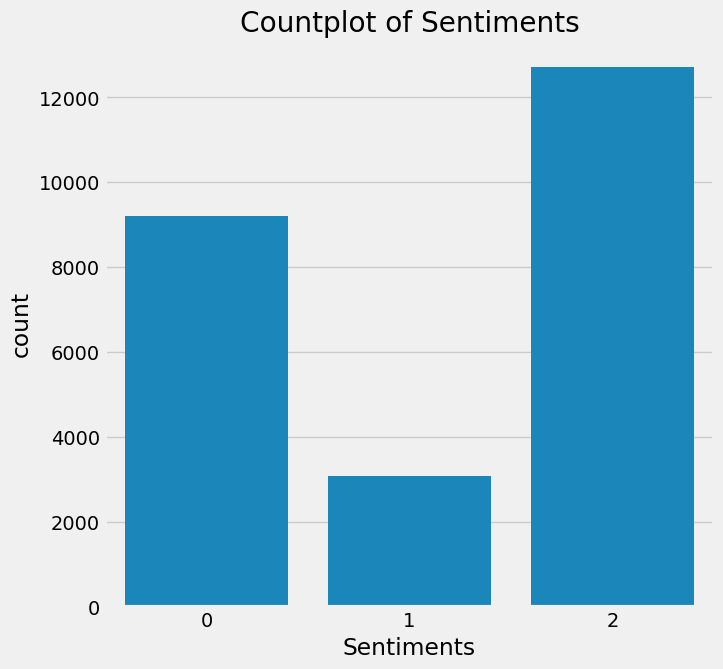

In [22]:
# Countplot of sentiments

fig = plt.figure(figsize=(7,7))
sns.countplot(x='sentiments', data = train)

plt.xlabel("Count of Tweets")
plt.xlabel("Sentiments")
plt.title("Countplot of Sentiments")

Text(0.5, 1.0, 'Distribution of sentiments')

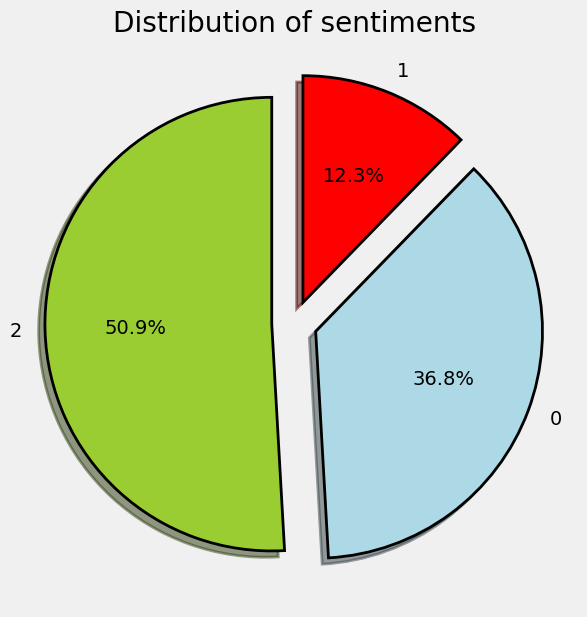

In [23]:
# Pie chart of distribution

fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "lightblue", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = train['sentiments'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label = '')
plt.title('Distribution of sentiments')

In [24]:
# Preparing the Data for Model

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

bow_vectorizer = CountVectorizer(max_df = 0.90 ,min_df = 2, max_features = 1000, stop_words = 'english')

def model_prep(df):
    # Bag of Words
    bow = bow_vectorizer.fit_transform(df['filtered_text'])

    X_train, X_test, y_train, y_test = train_test_split(bow, df['sentiments'],
                                                    test_size = 0.2, random_state = 69)

    return X_train, X_test, y_train, y_test

In [25]:
# Assigning test train values

X_train, X_test, y_train, y_test = model_prep(train)

In [26]:
# Check shape

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20000, 1000), (5000, 1000), (20000,), (5000,))

In [27]:
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes Classifier

model_naive = MultinomialNB()
model_naive.fit(X_train, y_train)
predicted_naive = model_naive.predict(X_test)

In [28]:
from sklearn.metrics import accuracy_score

score_naive = accuracy_score(predicted_naive, y_test)
print(f"Accuracy with Naive Bayes: {score_naive * 100 : .2f} %")

Accuracy with Naive Bayes:  74.04 %


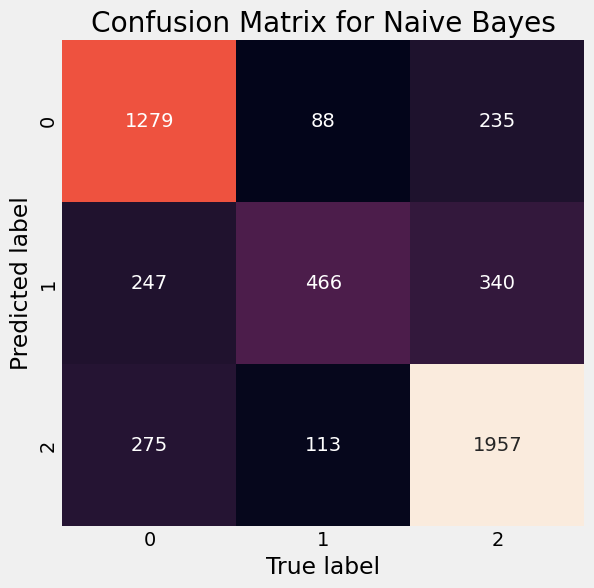

In [29]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(6,6))
mat_naive = confusion_matrix(y_test, predicted_naive)
sns.heatmap(mat_naive.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.savefig("confusion_matrix.png")
plt.show()

In [30]:
# XGBoost Classifier

from xgboost import XGBClassifier

model_xgb = XGBClassifier(max_depth = 6, n_estimators = 1000)
model_xgb.fit(X_train, y_train)
predicted_xgb = model_xgb.predict(X_test)

score_xgb = accuracy_score(predicted_xgb, y_test)
print(f"Accuracy with XGBoost Classifier: {score_xgb * 100 : .2f} %")

Accuracy with XGBoost Classifier:  86.92 %


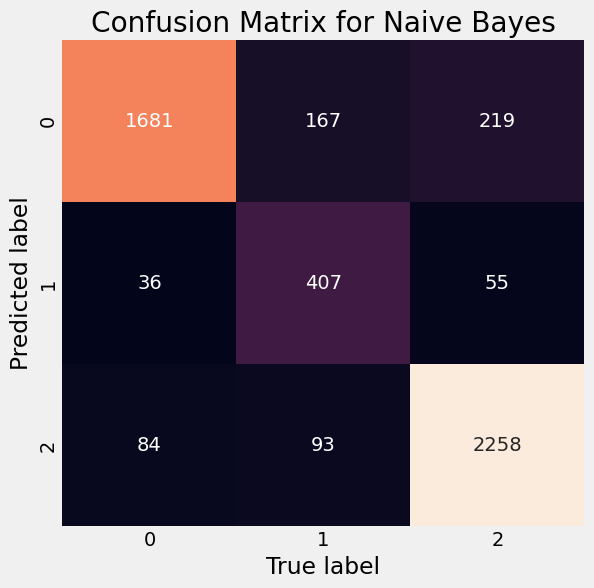

In [31]:
plt.figure(figsize=(6,6))
mat_xgb = confusion_matrix(y_test, predicted_xgb)
sns.heatmap(mat_xgb.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.savefig("confusion_matrix.png")
plt.show()

In [32]:
# Saving the Model

import joblib

model_nb = joblib.dump(model_naive, 'model_naive.pkl')
model_xgboost = joblib.dump(model_xgb, 'model_xgb.pkl')

In [34]:
# Selecting data for concept drift
test = pd.read_csv('gdrive/My Drive/Research/form/large_files/sen/test.csv')


In [35]:
# Applying the text preprocessing operations on test DataFrame

test = operations(test)

In [ ]:
test

,date,tweet,hashtag
0,2018-06-29 23:59:21+00:00,#Apple \nMy I Phone spellcheck gets worse and ...,apple
1,2018-06-29 23:45:57+00:00,"Song in Apple commercial.\n1st few times ""Wow,...",apple
2,2018-06-29 23:38:58+00:00,Happy 11th birthday iPhone!!!\n🎁🎂🎈🎉\n\n#iphone...,apple
3,2018-06-29 23:32:59+00:00,How great would it be if you could re-sell iPh...,apple
4,2018-06-29 23:22:36+00:00,Every day my new #MAC computer tells me that t...,apple
...,...,...,...
161599,NaN,NaN,NaN
161600,NaN,NaN,NaN
161601,NaN,NaN,NaN
161602,NaN,NaN,NaN


In [36]:
# Preparing test data for concept drift evaluation

from scipy.sparse import vstack, hstack

bow_test = bow_vectorizer.fit_transform(test['filtered_text'])
bow_train = bow_vectorizer.fit_transform(train['filtered_text'])

X_concat = vstack((bow_train, bow_test))
y_concat = np.concatenate((train['sentiments'], test['sentiments']), axis = 0)

In [37]:
X_concat.shape


(50261, 1000)

In [38]:
# Calculating step by step accuracies

def acc_calculator(df, step, model):

    accuracies = []

    for i in range(0, 25000, step):
        y_pred = model.predict(X_concat[i:i+step])
        accuracy = accuracy_score(y_pred, y_concat[i:i+step]) * 100
        accuracies.append(accuracy)

    return accuracies

In [39]:
acc_naive = acc_calculator(X_concat, 1000, model_naive)


Text(0, 0.5, 'Accuracy')

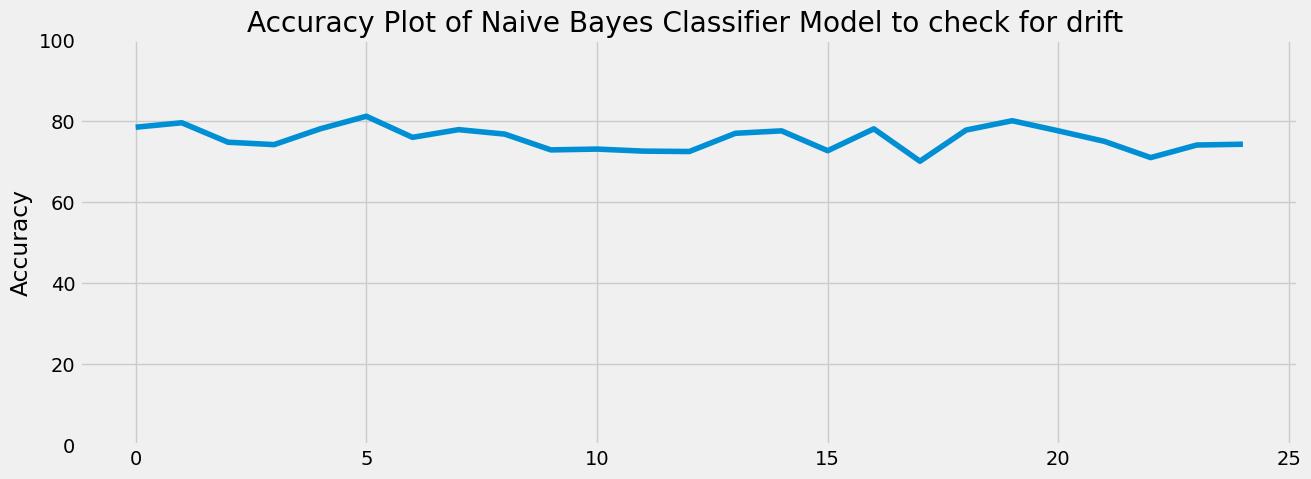

In [40]:
# Plotting Concept Drift for Naive Bayes Classifier

plt.figure(figsize=(14,5))
plt.plot(acc_naive)
plt.title("Accuracy Plot of Naive Bayes Classifier Model to check for drift ")
plt.ylim(0, 100)
plt.ylabel("Accuracy")

In [41]:
# Accuracies for XGBoost

acc_xgb = acc_calculator(X_concat, 1000, model_xgb)

Text(0, 0.5, 'Accuracy')

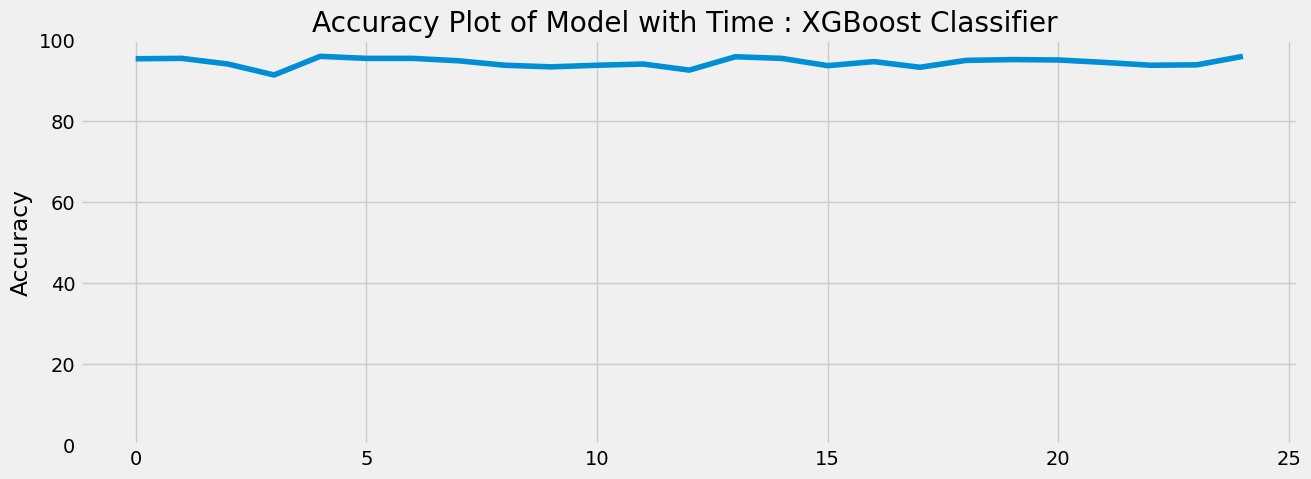

In [42]:
# Plotting Concept Drift for XGBoost Classifier

plt.figure(figsize=(14,5))
plt.plot(acc_xgb)
plt.title("Accuracy Plot of Model with Time : XGBoost Classifier ")
plt.ylim(0, 100)
plt.ylabel("Accuracy")